<a href="https://colab.research.google.com/github/VMBoehm/PAE/blob/fe_response/notebooks/tf2/Train_NSF_embeddings_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import copy

In [3]:
print(tf.__version__)

2.3.0


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [6]:
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Mounted at /content/drive


In [9]:
# loading embedding extracted from jupyter notebook
DATA_PATH = 'drive/My Drive/Revealing-Ferroelectric-Switching-Character-Using-Deep-Recurrent-Neural-Networks/embeddings/'
emb = np.load(os.path.join(DATA_PATH,'resonance_embeddings.npy'))

In [11]:
# finding non-zero embeddings
non_zero_dims = []
for ii in range(16):
    if len(np.where(emb[:,ii]!=0.)[0])>0:
        non_zero_dims.append(ii)
        
print(non_zero_dims)

[4, 6, 11, 15]


In [13]:
# latent size is smaller than embedding size due to sparsity
params={}
params['latent_size']=len(non_zero_dims)
params['embedding_size'] = emb.shape[-1]

# path for saving the model
params['module_dir'] = 'drive/My Drive/Revealing-Ferroelectric-Switching-Character-Using-Deep-Recurrent-Neural-Networks/modules/'

In [14]:
#n set your model parameters here
nvp_depth    = 6 #depth
dims         = np.asarray([4,4,4,4,4,4]) #width per layer
nvp_size     = np.arange(nvp_depth) 
indices      = np.arange(len(non_zero_dims))

In [15]:
# target distribution
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [16]:
## attempts to builda logit class
# class Logit(tfb.Bijector):

#     def __init__(self, validate_args=True, name='logit'):
#         super(Logit, self).__init__(validate_args=validate_args,
#         name=name,forward_min_event_ndims=0)

        
#         self.sigmoid = tfb.Sigmoid(validate_args=True)

#     def _forward(self, x):
#         return self.sigmoid.inverse(x+1e-4)+5

#     def _inverse(self, y):
#         return self.sigmoid.forward(y-5)-1e-4

#     def _inverse_log_det_jacobian(self, y):
#         return self.sigmoid.forward_log_det_jacobian(y)

#     def _forward_log_det_jacobian(self, x):
#         return self.sigmoid.inverse_log_det_jacobian(y)


In [17]:
# bijector for permutations (GLOW)

def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [61]:
# splines for Neural Spline Flow

class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        # you can try to take out layers here
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        # net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins-1)(net)
        net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [88]:
# model in good old tf1 style

tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])
data          = tf.placeholder(shape=[None,params['embedding_size']],dtype=tf.float32)
bs            = tf.placeholder_with_default(16,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
prior         = get_prior(params['latent_size'])

def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)

def get_nvp():
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']#np.repeat(np.arange(nvp_depth//2)/(nvp_depth//2),2)# np.repeat([0],nvp_depth)#
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        permutation   = np.random.permutation(np.arange(0, current_size))
        perms_rand.append(tfb.Permute(permutation=init_once(permutation,name="perm_rand%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)
    
    
#     chain.append(tfb.Scale(0.2))

# model can be composed of different element of GLOW, NSF, Real NVP, use the if statements for modifications
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<2: 
            # spline bijector
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<8 and i>4:
            # shift and scale 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            # shift
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
    # Neural spline flow needs to act on interval [-1,1], hence the scaling
    chain.append(tfb.Scale(5))

# in the future: can make logit part of the bijector
#    chain.append(Logit())
    
    # p(x) is Gaussian, chain: y=g(x)
    # bwd goes from last to first in the chain (inverse)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

# module to save the model
nvp_spec  = hub.create_module_spec(nvp_module_spec)
#uncomment this to load a module
#nvp_funcs = hub.Module(params['module_dir'], trainable=True)
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
# select non-zero dims
comp_data      = tf.gather(data,non_zero_dims,axis=1)
# apply logit trafo (other bijective preprocessing steps are possible)
comp_data_log  = tfb.Sigmoid(low=0, high=1.0).inverse(comp_data+1e-4)+5
#loss
loss           = -tf.reduce_mean(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])
#project into Gaussian space
bwd            = nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']
#draw from the Gaussian 
prior_sample   = prior.sample(bs)
# fwd model these draws back into the embedding space
sample         = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample},as_dict=True)['fwd_pass']
opt_op_nvp = optimizer.minimize(loss)


4 [4]
4 [4, 4]
4 [4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4, 4]
4 [4, 4, 4, 4, 4, 4]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [89]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [90]:
comp_emb_log, comp_emb, bwd = sess.run([comp_data_log, comp_data, bwd], feed_dict={data:emb})

In [91]:
print(max(comp_emb.flatten()), min(comp_emb.flatten()))
print(max(comp_emb_log.flatten()), min(comp_emb_log.flatten()))
print(max(bwd.flatten()), min(bwd.flatten()), np.mean(bwd))

0.06903684 0.0
2.3999753 -4.2102404
0.8057451 -2.2221756 -0.3549672


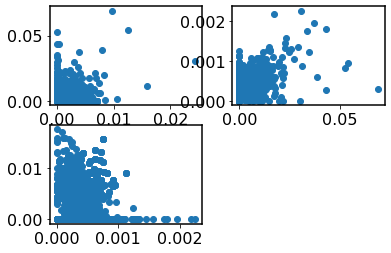

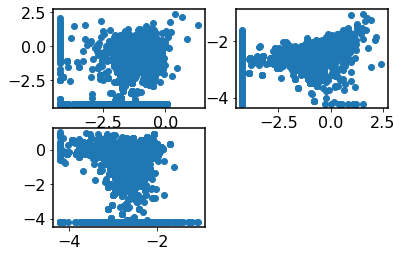

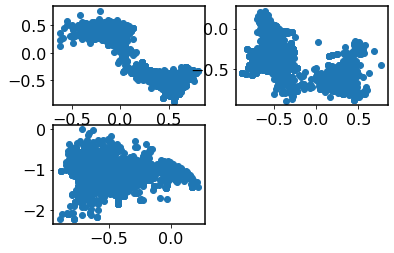

In [92]:
# input data (embedding)
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(comp_emb[:,ii],comp_emb[:,ii+1])
plt.show()   
# input data after logit transform
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(comp_emb_log[:,ii],comp_emb_log[:,ii+1])
plt.show()
# input data in 'Gaussian' space
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(bwd[:,ii],bwd[:,ii+1])

In [93]:
# a quick check if everything's working
learning_rate = 1e-3
sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:emb})

[None, 10.686831]

In [94]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [95]:
# training
learning_rate = 1e-2
batchsize = 8
train_size = len(emb)
epoch = len(emb)//batchsize
train_size = int(len(emb)/6*5)
print('sample size of training sample', train_size)
z_sample = emb[:train_size]
z_sample_valid = emb[train_size:,] 
valid_size = len(z_sample_valid)
print('sample size of validation sample', valid_size)
z_sample_train = z_sample[:]
n_epochs = 200
break_count =0
while ii<n_epochs:
    print('epoch ', ii)
    jj = 0
    if ii>10:
        batchsize = 16
        learning_rate = 1e-3
    if ii>30:
        batchsize = 32
    if ii>40:
        learning_rate=1e-4
    if ii>60:
        batch_size=16
    if ii>180:
        batch_size=8
    if ii>200:
        batch_size=16
    if ii>250:
        learning_rate=1e-3
    if ii>300:
        learning_rate=1e-4    
    if ii>330:
        batch_size=32
    epoch = train_size//batchsize
    while jj<epoch:
        # adding noise didnt really work
        noise= 0.#np.abs(np.random.randn(batchsize,params['embedding_size'])*1e-6)
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample_train[jj*batchsize:(jj+1)*batchsize]+noise})
        if jj%200==0 and ii%2==0:
            np.random.shuffle(z_sample_valid)
            l_v = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})
            nvp_vloss+=[l_v]
            inds = np.random.randint(low=0, high=train_size, size=1024)
            l_t = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample[inds]})
            nvp_tloss+=[l_t]
            print(l_t, l_v,break_count)
            if l_v>l_t:
                break_count+=1.
            if l_t<l_v:
                break_count=0.
        if break_count>100:
            break
        jj+=1
    np.random.shuffle(z_sample) 
    # mixing a little
    if ii%100==0 and ii != 0:
        z_ = copy.copy(z_sample_valid)
        z_sample_valid = copy.copy(z_sample[0:valid_size])
        z_sample[0:valid_size] = z_
    if ii%20==0 and ii>0:
      # saves the model at regular intervals
        nvp_path = os.path.join(params['module_dir'],'run1_nepoch%d'%ii)
        try:
            nvp_funcs.export(nvp_path,sess)
        except:
            pass
    z_sample_train = copy.copy(z_sample)
    ii+=1

sample size of training sample 3000
sample size of validation sample 600
epoch  0
10.239693 10.173185 0
6.138102 5.694817 0
epoch  1
epoch  2
4.881154 4.1194644 0
4.066147 3.5977178 0
epoch  3
epoch  4
3.2110007 2.7937174 0
4.2771206 3.9331942 0
epoch  5
epoch  6
3.850045 3.5162082 0
3.0759695 2.7452247 0
epoch  7
epoch  8
3.209334 2.7198896 0
2.3974235 1.9609982 0
epoch  9
epoch  10
2.647478 1.8800185 0
2.3939435 1.9407651 0
epoch  11
epoch  12
2.5245676 1.9858203 0
epoch  13
epoch  14
1.6407756 1.1284642 0
epoch  15
epoch  16
1.3542149 0.8224498 0
epoch  17
epoch  18
1.1710429 0.54458797 0
epoch  19
epoch  20
1.2635362 0.42898813 0
epoch  21
epoch  22
0.5195422 0.009532097 0
epoch  23
epoch  24
0.7090713 0.16919906 0
epoch  25
epoch  26
1.8891828 1.5656985 0
epoch  27
epoch  28
0.61397064 -0.008535603 0
epoch  29
epoch  30
0.40808105 -0.22434352 0
epoch  31
epoch  32
0.029342614 -0.5454376 0
epoch  33
epoch  34
0.13421151 -0.52960503 0
epoch  35
epoch  36
0.08968566 -0.58063674 0
epo

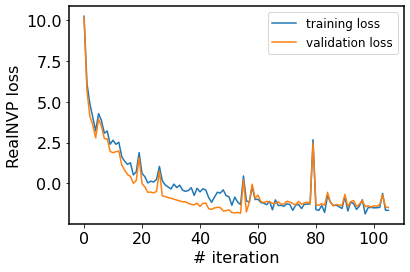

In [96]:
plt.figure()
plt.plot(nvp_tloss,label='training loss')
plt.plot(nvp_vloss,label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()

In [102]:
# nvp_path = os.path.join(params['module_dir'],'run2_nepoch%d'%ii)
# nvp_funcs.export(nvp_path,sess)

In [97]:
bwd_train = sess.run(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'],  feed_dict={data:z_sample})
bwd_valid = sess.run(nvp_funcs({'z_sample':comp_data_log,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'],  feed_dict={data:z_sample_valid})
prior_sample = sess.run(prior_sample,  feed_dict={bs:len(z_sample)})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


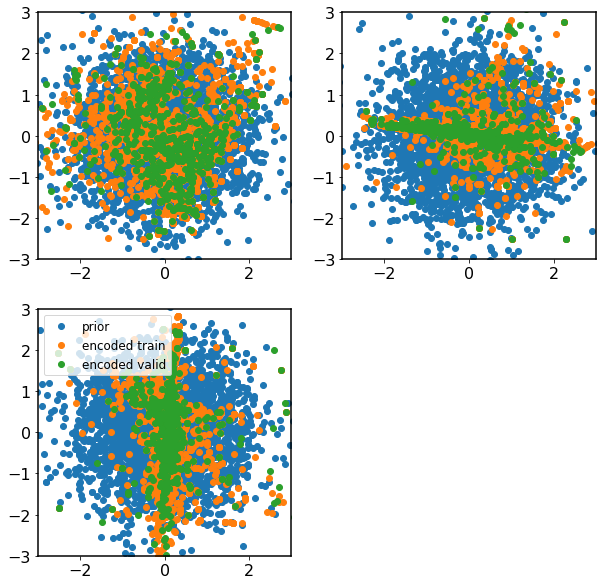

In [98]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(prior_sample[:,nn],prior_sample[:,nn+1], label='prior')
    plt.scatter(bwd_train[:,nn],bwd_train[:,nn+1],label='encoded train')
    plt.scatter(bwd_valid[:,nn],bwd_valid[:,nn+1], label='encoded valid')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend()
plt.show()

In [99]:
fwd_sample = sess.run(sample, feed_dict={bs:len(z_sample)})

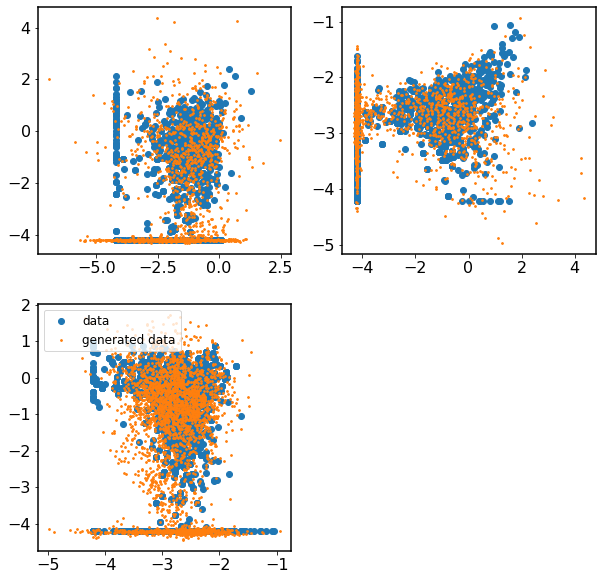

In [100]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(comp_emb_log[:,nn],comp_emb_log[:,nn+1], label='data')
    plt.scatter(fwd_sample[:,nn],fwd_sample[:,nn+1],s=3, label='generated data')
plt.legend()